In [1]:
# ====================================
# 1. Import Libraries
# ====================================
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm  # progress bar

# Check device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cpu


In [4]:
# ====================================
# 2. Dataset Loader
# ====================================
class CrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        normal_dir = os.path.join(root_dir, "Normal")
        crack_dir = os.path.join(root_dir, "Crack")

        # Normal class = 0
        for img_name in os.listdir(normal_dir):
            if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                self.samples.append((os.path.join(normal_dir, img_name), 0))

        # Crack class = 1
        for img_name in os.listdir(crack_dir):
            if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                self.samples.append((os.path.join(crack_dir, img_name), 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


# Image transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

DATASET_DIR = "Crack Dataset/train"  # <-- adjust path if needed
dataset = CrackDataset(DATASET_DIR, transform=transform)

# Train loader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

print("Dataset size:", len(dataset))


Dataset size: 30000


In [2]:
# ====================================
# 3. U-Net Model with Classification Head
# ====================================
class UNet(nn.Module):
    def __init__(self, n_classes=1):
        super(UNet, self).__init__()
        self.enc1 = self.contracting_block(3, 64)
        self.enc2 = self.contracting_block(64, 128)
        self.enc3 = self.contracting_block(128, 256)

        self.bottom = self.contracting_block(256, 512)

        self.up3 = self.expansive_block(512, 256)
        self.up2 = self.expansive_block(256, 128)
        self.up1 = self.expansive_block(128, 64)

        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

        # Classifier head (Normal vs Crack)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 2)   # 2 classes
        )

    def contracting_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        return block

    def expansive_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        return block

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)

        bottom = self.bottom(enc3)

        # classification head
        class_logits = self.classifier(bottom)

        dec3 = self.up3(bottom)
        dec2 = self.up2(dec3)
        dec1 = self.up1(dec2)

        mask = torch.sigmoid(self.final(dec1))  # segmentation output
        return mask, class_logits


model = UNet().to(DEVICE)
print(model)


UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottom): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Re

In [4]:
# ====================================
# 4. Training Setup
# ====================================
criterion_class = nn.CrossEntropyLoss()
criterion_seg = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 5


In [5]:
# ====================================
# 5. Training Loop
# ====================================
for epoch in range(EPOCHS):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        seg_out, class_out = model(images)

        # classification loss
        loss_class = criterion_class(class_out, labels)

        # fake zero masks (since no segmentation GT in dataset)
        fake_masks = torch.zeros_like(seg_out)
        loss_seg = criterion_seg(seg_out, fake_masks)

        # total loss
        loss = loss_class + 0.1 * loss_seg
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = class_out.argmax(dim=1)
        total_correct += (preds == labels).sum().item()

    acc = total_correct / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}, Acc: {acc:.4f}")


Epoch 1/5: 100%|██████████| 1875/1875 [46:12:44<00:00, 88.73s/it]        


Epoch 1/5, Loss: 535.2980, Acc: 0.8773


Epoch 2/5: 100%|██████████| 1875/1875 [3:45:36<00:00,  7.22s/it]  


Epoch 2/5, Loss: 239.8149, Acc: 0.9565


Epoch 3/5: 100%|██████████| 1875/1875 [3:23:55<00:00,  6.53s/it]  


Epoch 3/5, Loss: 94.8590, Acc: 0.9855


Epoch 4/5: 100%|██████████| 1875/1875 [22:27:45<00:00, 43.13s/it]      


Epoch 4/5, Loss: 63.9423, Acc: 0.9904


Epoch 5/5: 100%|██████████| 1875/1875 [14:29:19<00:00, 27.82s/it]      

Epoch 5/5, Loss: 50.8680, Acc: 0.9926


In [6]:
# ====================================
# 6. Save Model
# ====================================
torch.save(model.state_dict(), "crack_unet.pth")
print("✅ Model saved!")


✅ Model saved!


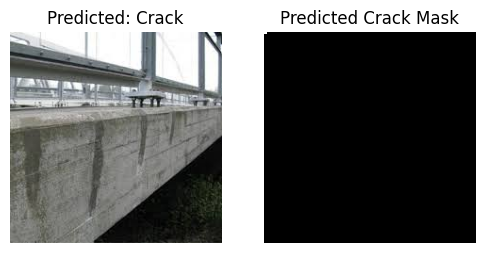

✅ Prediction: Crack


In [4]:
# ====================================
# 7. Testing / Inference
# ====================================
import matplotlib.pyplot as plt

# Reload model for testing
model = UNet().to(DEVICE)
model.load_state_dict(torch.load("crack_unet.pth", map_location=DEVICE))
model.eval()

# Class labels
class_names = ["Normal", "Crack"]

def predict_image(img_path):
    """Run inference on a single image and show result."""
    img = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        seg_out, class_out = model(tensor)
        pred_class = class_out.argmax(dim=1).item()
        pred_label = class_names[pred_class]

    # show
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Predicted: {pred_label}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(seg_out.squeeze().cpu(), cmap="gray")
    plt.title("Predicted Crack Mask")
    plt.axis("off")
    plt.show()

    return pred_label


# Example: test on one image
test_image_path = "test/test 2.jpg"  # <-- replace with real test image path
prediction = predict_image(test_image_path)
print("✅ Prediction:", prediction)
